In [1]:
import nltk
from nltk import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import time
import re
import numpy as np
import pandas as pd
import json
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#BeautifulSoup
from bs4 import BeautifulSoup
import requests

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.doc2vec import LabeledSentence

# spacy for lemmatization
import spacy

# Plotting tools FOR TOPIC MODELING
import pyLDAvis
import pyLDAvis.gensim  # don't skip this


# Enable logging for gensim - optional  (I HAVEN'T USED THIS YET)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


# NLTK Stop words -------------- ADD TO THESE AS WE SEE FIT
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle

pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

# Import Novels

In [2]:
first_fifty = pickle.load( open( "pickled_novel_dict_0_50", "rb" ) )

In [3]:
second_fifty = pickle.load( open( "pickled_novel_dict_50_100", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [4]:
titles = []

In [5]:
for i in first_fifty.keys():
    titles.append(i)

In [6]:
for i in second_fifty.keys():
    titles.append(i)

In [7]:
len(titles)

99

# Tokenize, Clean, and Tag Functions

In [10]:
def p_ize(novel):    
    broken = []
    start = 0
    end = 1200
    final = len(novel)
    while start < final:
        broken.append(novel[start:end])
        start += 1200
        end += 1200
    return broken

In [11]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

In [12]:
def lexicon(input_data):
    lowered = input_data.lower()
    tokens = tokenizer.tokenize(lowered)
    nonstop_tokens = list(set(tokens).difference(stopword_set))
    return nonstop_tokens

In [13]:
def token_keep_stop(input_data):
    lowered = input_data.lower()
    tokens = tokenizer.tokenize(lowered)
    return tokens

In [14]:
def token_no_stop(input_data):
    lowered = input_data.lower()
    tokens = tokenizer.tokenize(lowered)
    nonstop_tokens = [token for token in tokens if token not in stopword_set]
    return nonstop_tokens

# Word, Paragraph, and Lexicon Creation

In [15]:
book_word_length_0_50 = []
book_word_length_no_stop_0_50 = []
book_lexicon_length_0_50 = []

for i in list(first_fifty.values()):
    length = len(token_keep_stop(i))
    book_word_length_0_50.append(length)
    
    length_no_stop = len(token_no_stop(i))
    book_word_length_no_stop_0_50.append(length_no_stop)

    length_lexicon = len(lexicon(i))
    book_lexicon_length_0_50.append(length_lexicon)

In [16]:
len(book_word_length_0_50)

49

In [17]:
book_word_length_50_100 = []
book_word_length_no_stop_50_100 = []
book_lexicon_length_50_100 = []

for i in list(second_fifty.values()):
    length = len(token_keep_stop(i))
    book_word_length_50_100.append(length)
    
    length_no_stop = len(token_no_stop(i))
    book_word_length_no_stop_50_100.append(length_no_stop)

    length_lexicon = len(lexicon(i))
    book_lexicon_length_50_100.append(length_lexicon)

In [18]:
len(book_word_length_50_100)

50

In [19]:
book_word_length = book_word_length_0_50 + book_word_length_50_100

In [20]:
lexicon_length = book_lexicon_length_0_50 + book_lexicon_length_50_100

In [21]:
paragraph_count_0_50 = [len(p_ize(i))for i in first_fifty.values()]

In [22]:
paragraph_count_50_100 = [len(p_ize(i))for i in second_fifty.values()]

In [23]:
paragraph_count = paragraph_count_0_50 + paragraph_count_50_100

# DataFrames of Novels and Paragraphs

## Novels as a Whole

In [43]:
novels = pd.DataFrame()

In [44]:
novels['title'] = titles

In [45]:
novels['word_count'] = book_word_length

In [46]:
novels['lexicon_count'] = lexicon_length

In [47]:
novels['lex_total_ratio'] = novels.lexicon_count/novels.word_count

In [48]:
novels['paragraph_count'] = paragraph_count

### Literary-ness

**Following hyperparameters can be played with (word count and lex_total_ratio) to find the sweet spot of 'wordy' or 'literary' novels/paragraphs.**

In [49]:
novels['over_150k_words_5perc_lex'] = np.where((novels.word_count > 150000) & (novels.lex_total_ratio >.05), 1, 0)



In [54]:
novels

,title,word_count,lexicon_count,lex_total_ratio,paragraph_count,over_150k_words_5perc_lex
0,Pride and Prejudice,122876,6187,0.050352,568,0
1,FrankensteinOrThe Modern Prometheus,78092,7068,0.090509,363,0
2,A Journal of the Plague Year,94304,5573,0.059096,423,0
3,The Importance of Being EarnestA Trivial Comed...,21045,2481,0.117890,97,0
4,The Works of Edgar Allan PoeThe Raven Edition,423370,21029,0.049671,1981,0
5,Alice's Adventures in Wonderland,27156,2400,0.088378,118,0
6,The Call of the Wild,32261,4588,0.142215,146,0
7,Et dukkehjemEnglish,27245,2261,0.082988,117,0
8,A Modest Proposal,3397,983,0.289373,17,0
9,The Strange Case of DrJekyll and MrHyde,25865,3791,0.146569,115,0


In [75]:
most_literary = list(novels[novels.over_150k_words_5perc_lex == 1].title.values)

In [76]:
most_literary

['Moby DickOrThe Whale',
 'Little Women',
 'Dracula',
 'Jane EyreAn Autobiography',
 'Great Expectations',
 'Ulysses',
 'Oliver Twist',
 "Uncle Tom's Cabin",
 'The Jungle',
 'The Slang DictionaryEtymologicalHistorical and Andecdotal']

## Paragraphs

In [61]:
text = list(zip(titles,(list(first_fifty.values()) + list(second_fifty.values()))))

In [62]:
final = []
for i in text:
    name = i[0]
    paragraphs = p_ize(i[1])
    for i in paragraphs:
        final.append((name,i))

In [63]:
paragraphs = pd.DataFrame()

In [64]:
titles_p = [i[0] for i in final]

In [65]:
para_p = [i[1] for i in final]

In [66]:
paragraphs['title'] = titles_p

In [67]:
paragraphs['chunks'] = para_p

In [68]:
paragraphs['tokens'] = paragraphs['chunks'].map(lexicon)

In [69]:
paragraphs['tag'] = [str(i) for i in paragraphs.index]

In [70]:
paragraphs['token_count'] = [len(i) for i in paragraphs.tokens]

### Literary-ness

**Same hyperparameter idea s above for determining the most wordy or literary paragraphs.**

In [77]:
paragraphs['high_lexicon'] = np.where(paragraphs.token_count > 125, 1, 0)

In [78]:
paragraphs

,title,chunks,tokens,tag,token_count,high_lexicon
0,Pride and Prejudice,CONTENTS Chapter 1 Chapter 2 Chapter 3 Chapte...,"[man, park, 33, 4, fortune, however, 51, 9, 13...",0,105,0
1,Pride and Prejudice,"s,” returned she; “for Mrs. Long has just been...","[man, thinking, young, fortune, large, chaise,...",1,77,0
2,Pride and Prejudice,m as soon as he comes.” “I see no occasion for...,"[soon, thinking, send, ought, visit, occasion,...",2,73,0
3,Pride and Prejudice,rd for my little Lizzy.” “I desire you will do...,"[upon, many, young, better, odd, hope, way, ex...",3,85,0
4,Pride and Prejudice,to make his wife understand his character. He...,"[till, hope, fancied, observing, way, hypocrit...",4,83,0
...,...,...,...,...,...,...
54721,Second Treatise of Government,or a foreign nation; and in this lies the inj...,"[subjects, upon, author, principles, could, ri...",54721,87,0
54722,Second Treatise of Government,"ers and people, that as former ages never coul...","[reposed, could, 240, redeemed, question, ages...",54722,90,0
54723,Second Treatise of Government,"nd dangerous? Sect. 241. But farther, this que...","[man, reposed, common, whether, prince, acts, ...",54723,73,0
54724,Second Treatise of Government,"to heaven; force between either persons, who h...","[successors, assembly, upon, ever, individuals...",54724,73,0


In [74]:
list(set(paragraphs[paragraphs['high_lexicon'] == 1].title.values))

['Little Women',
 'The Decameron of Giovanni Boccaccio',
 'Index of Project Gutenberg Works on Black History',
 'Ulysses',
 'The Slang DictionaryEtymologicalHistorical and Andecdotal',
 'Second Treatise of Government',
 'The Iliad',
 'Geschlecht und CharakterEnglish',
 "La Navigation Aérienne L'aviation Et La Direction Des Aérostats Dans Les Temps Anciens Et Modernes",
 'BeowulfAn Anglo-Saxon Epic Poem',
 'Wuthering Heights',
 'The MemoirsCorrespondenceAnd MiscellaniesFrom The Papers Of Thomas Jefferson',
 'Also sprach ZarathustraEnglish',
 'The Works of Edgar Allan PoeThe Raven Edition',
 'The Picture of Dorian Gray']

# EDA

## Novel EDA

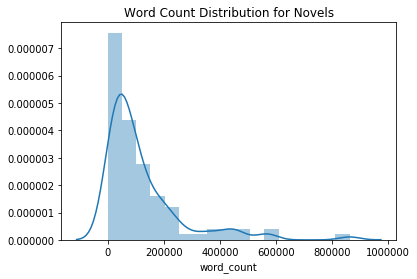

In [100]:
sns.distplot(novels.word_count)
plt.title('Word Count Distribution for Novels')
plt.show()

In [90]:
novels.word_count.describe()

count        99.000000
mean     121642.050505
std      144632.943993
min          94.000000
25%       37211.500000
50%       70054.000000
75%      155955.000000
max      862471.000000
Name: word_count, dtype: float64

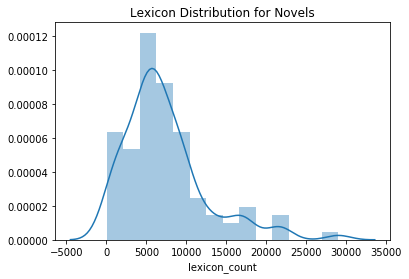

In [101]:
sns.distplot(novels.lexicon_count)
plt.title('Lexicon Distribution for Novels')
plt.show()

In [92]:
novels.lexicon_count.describe()

count       99.000000
mean      7267.262626
std       5267.477444
min         49.000000
25%       4248.500000
50%       6412.000000
75%       9094.500000
max      29012.000000
Name: lexicon_count, dtype: float64

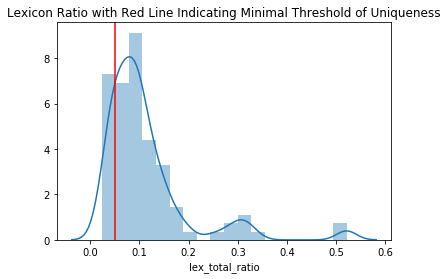

In [103]:
sns.distplot(novels.lex_total_ratio)
plt.axvline(.05, color='red')
plt.title('Lexicon Ratio with Red Line Indicating Minimal Threshold of Uniqueness')
plt.show()

In [94]:
novels.lex_total_ratio.describe()

count    99.000000
mean      0.111024
std       0.088999
min       0.022730
25%       0.056793
50%       0.088378
75%       0.121077
max       0.521277
Name: lex_total_ratio, dtype: float64

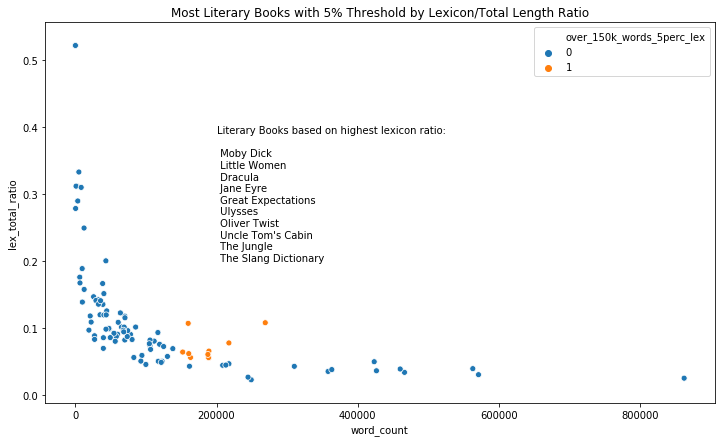

In [97]:
plt.figure(figsize=(12,7))
sns.scatterplot(novels.word_count, novels.lex_total_ratio, hue=novels.over_150k_words_5perc_lex)
plt.text(200000,.2, "Literary Books based on highest lexicon ratio: \n\n Moby Dick \n Little Women \n Dracula \n Jane Eyre \n Great Expectations \n Ulysses \n Oliver Twist \n Uncle Tom's Cabin \n The Jungle \n The Slang Dictionary")
plt.title('Most Literary Books with 5% Threshold by Lexicon/Total Length Ratio')
plt.show()

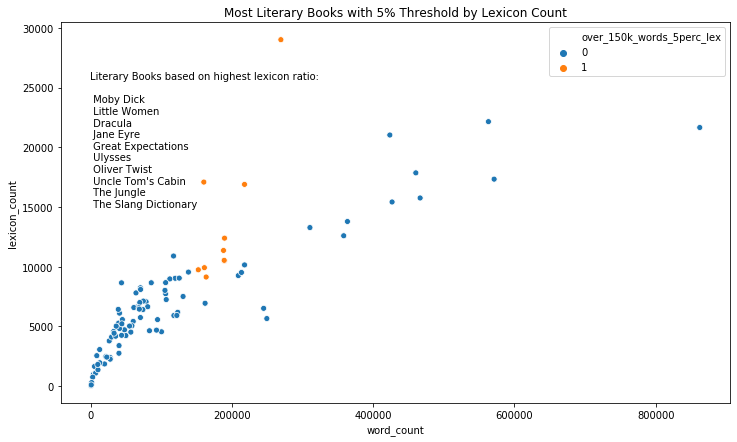

In [99]:
plt.figure(figsize=(12,7))
sns.scatterplot(novels.word_count, novels.lexicon_count, hue=novels.over_150k_words_5perc_lex)
plt.text(-1000,15000, "Literary Books based on highest lexicon ratio: \n\n Moby Dick \n Little Women \n Dracula \n Jane Eyre \n Great Expectations \n Ulysses \n Oliver Twist \n Uncle Tom's Cabin \n The Jungle \n The Slang Dictionary")
plt.title('Most Literary Books with 5% Threshold by Lexicon Count')
plt.show()

## Paragraph EDA

**Display of paragraphs above a certain literary threshold (125 unique words per paragraph) and their associated book titles below**

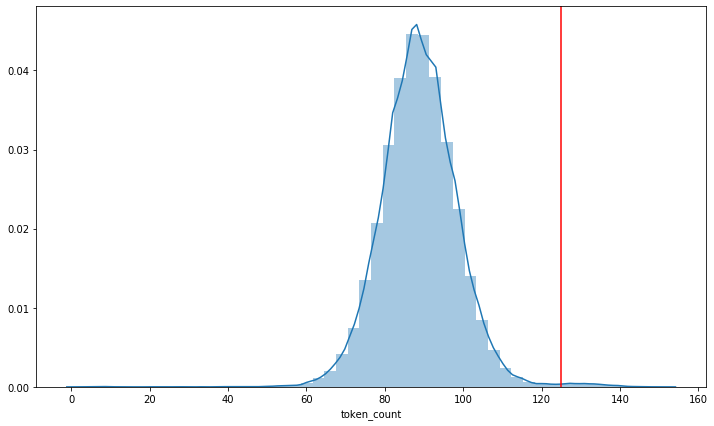

In [87]:
plt.figure(figsize=(12,7))
sns.distplot(paragraphs.token_count)
plt.axvline(125, color='red')
plt.show()

In [88]:
list(set(paragraphs[paragraphs['high_lexicon'] == 1].title.values))

['Little Women',
 'The Decameron of Giovanni Boccaccio',
 'Index of Project Gutenberg Works on Black History',
 'Ulysses',
 'The Slang DictionaryEtymologicalHistorical and Andecdotal',
 'Second Treatise of Government',
 'The Iliad',
 'Geschlecht und CharakterEnglish',
 "La Navigation Aérienne L'aviation Et La Direction Des Aérostats Dans Les Temps Anciens Et Modernes",
 'BeowulfAn Anglo-Saxon Epic Poem',
 'Wuthering Heights',
 'The MemoirsCorrespondenceAnd MiscellaniesFrom The Papers Of Thomas Jefferson',
 'Also sprach ZarathustraEnglish',
 'The Works of Edgar Allan PoeThe Raven Edition',
 'The Picture of Dorian Gray']

# Doc2Vec Model Building

In [104]:
model = pickle.load(open("first_model", "rb"))

In [18]:
# MODEL PARAMETERS
dm = 1 # 1 for distributed memory(default); 0 for dbow 
size = 300
context_window = 50
seed = 42
min_count = 1
alpha = 0.5
max_iter = 200

In [95]:
# BUILD MODEL
model = gensim.models.doc2vec.Doc2Vec(documents = tagged,
dm = dm,
alpha = alpha, # initial learning rate
seed = seed,
min_count = min_count, # ignore words with freq less than min_count
max_vocab_size = None, # 
window = context_window, # the number of words before and after to be used as context
size = size, # is the dimensionality of the feature vector
sample = 1e-4, # ?
negative = 5, # ? # number of cores
epochs = max_iter) 

/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [149]:
dubulys = paragraphs[(paragraphs.title == 'Dubliners') ^ (paragraphs.title == 'Ulysses')]

In [151]:
dubulys.chunks

21820     Stately, plump Buck Mulligan came from the st...
21821    es, gents. One moment. A little trouble about ...
21822    the buck himself. We must go to Athens. Will y...
21823    from his perch and began to search his trouser...
21824    led your mother, he said. That’s why she won’t...
                               ...                        
28598     out together, walking, you know, Gabriel, lik...
28599     I was only a week in the convent he died and ...
28600    eath. Perhaps she had not told him all the sto...
28601    ong under the sheets and lay down beside his w...
28602     come for him to set out on his journey westwa...
Name: chunks, Length: 1558, dtype: object

In [152]:
tokensdubulys = [lexicon(i) for i in dubulys.chunks]

In [164]:
tagdubulys = [TaggedDocument(words=chunk, tags=[str(i)]) for i, chunk in zip(dubulys.index,tokensdubulys)]

In [166]:
# MODEL PARAMETERS
dm = 1 # 1 for distributed memory(default); 0 for dbow 
size = 300
context_window = 50
seed = 42
min_count = 1
alpha = 0.5
max_iter = 200

# BUILD MODEL
modeldubulys = gensim.models.doc2vec.Doc2Vec(documents = tagdubulys,
dm = dm,
alpha = alpha, # initial learning rate
seed = seed,
min_count = min_count, # ignore words with freq less than min_count
max_vocab_size = None, # 
window = context_window, # the number of words before and after to be used as context
size = size, # is the dimensionality of the feature vector
sample = 1e-4, # ?
negative = 5, # ? # number of cores
epochs = max_iter) 

In [168]:
modeldubulys.docvecs.most_similar('21820')

[('22938', 0.5749445557594299),
 ('28547', 0.5626740455627441),
 ('21834', 0.5603097081184387),
 ('22372', 0.5582675933837891),
 ('22726', 0.5580608248710632),
 ('28586', 0.5362993478775024),
 ('21961', 0.5355404615402222),
 ('22315', 0.5246682167053223),
 ('22822', 0.5182522535324097),
 ('22015', 0.5177793502807617)]

In [169]:
dubulys.chunks[21820]

' Stately, plump Buck Mulligan came from the stairhead, bearing a bowl of lather on which a mirror and a razor lay crossed. A yellow dressinggown, ungirdled, was sustained gently behind him on the mild morning air. He held the bowl aloft and intoned: —Introibo ad altare Dei. Halted, he peered down the dark winding stairs and called out coarsely: —Come up, Kinch! Come up, you fearful jesuit! Solemnly he came forward and mounted the round gunrest. He faced about and blessed gravely thrice the tower, the surrounding land and the awaking mountains. Then, catching sight of Stephen Dedalus, he bent towards him and made rapid crosses in the air, gurgling in his throat and shaking his head. Stephen Dedalus, displeased and sleepy, leaned his arms on the top of the staircase and looked coldly at the shaking gurgling face that blessed him, equine in its length, and at the light untonsured hair, grained and hued like pale oak. Buck Mulligan peeped an instant under the mirror and then covered the b

In [172]:
dubulys.chunks[22372]

' to take a hold of a fellow the like of that and throw him in the bloody sea. Justifiable homicide, so it would. Then sloping off with his five quid without putting up a pint of stuff like a man. Give us your blessing. Not as much as would blind your eye. —Charity to the neighbour, says Martin. But where is he? We can’t wait. —A wolf in sheep’s clothing, says the citizen. That’s what he is. Virag from Hungary! Ahasuerus I call him. Cursed by God. —Have you time for a brief libation, Martin? says Ned. —Only one, says Martin. We must be quick. J. J. and S. —You, Jack? Crofton? Three half ones, Terry. —Saint Patrick would want to land again at Ballykinlar and convert us, says the citizen, after allowing things like that to contaminate our shores. —Well, says Martin, rapping for his glass. God bless all here is my prayer. —Amen, says the citizen. —And I’m sure He will, says Joe. And at the sound of the sacring bell, headed by a crucifer with acolytes, thurifers, boatbearers, readers, osti

In [96]:
# pickle.dump(model, open("first_model", "wb" ))

In [108]:
all_tokens = [lexicon(i) for i in paragraphs.chunks.values]

In [109]:
tagged = [TaggedDocument(words=chunk, tags=[str(i)]) for i, chunk in enumerate(all_tokens)]

In [113]:
tagged[:3]

[TaggedDocument(words=['man', 'park', '33', '4', 'fortune', 'however', '51', '9', '13', 'fixed', '14', '18', '28', '27', 'let', 'netherfield', '61', 'wife', 'feelings', 'rightful', '6', '8', 'one', '44', 'lady', 'entering', '12', '21', '5', 'families', '52', '26', '45', 'said', '23', 'contents', '20', 'universally', '3', '19', 'views', 'bennet', 'replied', '41', '29', '25', '34', '54', '55', 'known', 'mr', 'property', 'want', '17', '40', '58', 'surrounding', 'chapter', 'may', 'daughters', '56', '38', '32', 'well', '2', '1', 'dear', '57', '49', 'considered', '42', '7', 'must', '39', '35', '50', '15', 'single', '16', '48', '47', 'truth', '46', '53', '60', 'possession', 'good', '24', 'day', '11', 'heard', '10', '31', 'neighbourhood', '36', '37', '30', '43', 'minds', 'last', '59', 'first', 'little', 'acknowledged', '22'], tags=['0']),
 TaggedDocument(words=['man', 'thinking', 'young', 'fortune', 'large', 'chaise', 'settling', 'next', 'monday', 'marrying', 'netherfield', 'wife', 'nonsense',

In [127]:
paragraphs[paragraphs.title == 'Ulysses'][-1:]

,title,chunks,tokens,tag,token_count,high_lexicon
23071,Ulysses,he queer little streets and the pink and blue ...,"[wall, kissed, thought, breasts, streets, rose...",23071,54,0


In [117]:
model.docvecs.similarity('2', '3')

0.17893314

In [120]:
model.docvecs.similarity('2', '14900')

0.9053892

In [131]:
model.docvecs.most_similar('23070')

[('45076', 0.904321014881134),
 ('7352', 0.8949985504150391),
 ('361', 0.8947805166244507),
 ('14711', 0.8907774090766907),
 ('22965', 0.8873056173324585),
 ('32064', 0.8865193128585815),
 ('49821', 0.8840922713279724),
 ('44160', 0.8840197920799255),
 ('24582', 0.8839969038963318),
 ('19854', 0.8830661773681641)]

In [132]:
paragraphs.chunks[23070]

'ilors playing all birds fly and I say stoop and washing up dishes they called it on the pier and the sentry in front of the governors house with the thing round his white helmet poor devil half roasted and the Spanish girls laughing in their shawls and their tall combs and the auctions in the morning the Greeks and the jews and the Arabs and the devil knows who else from all the ends of Europe and Duke street and the fowl market all clucking outside Larby Sharons and the poor donkeys slipping half asleep and the vague fellows in the cloaks asleep in the shade on the steps and the big wheels of the carts of the bulls and the old castle thousands of years old yes and those handsome Moors all in white and turbans like kings asking you to sit down in their little bit of a shop and Ronda with the old windows of the posadas 2 glancing eyes a lattice hid for her lover to kiss the iron and the wineshops half open at night and the castanets and the night we missed the boat at Algeciras the wat

In [133]:
paragraphs.chunks[45076]

'hat lady’s path. ‘And yet, sir,’ he would say, ‘how does it turn out after all? Why here she is at a hundred a year (I give her a hundred, which she is pleased to term handsome), keeping the house of Josiah Bounderby of Coketown!’ Nay, he made this foil of his so very widely known, that third parties took it up, and handled it on some occasions with considerable briskness. It was one of the most exasperating attributes of Bounderby, that he not only sang his own praises but stimulated other men to sing them. There was a moral infection of clap-trap in him. Strangers, modest enough elsewhere, started up at dinners in Coketown, and boasted, in quite a rampant way, of Bounderby. They made him out to be the Royal arms, the Union-Jack, Magna Charta, John Bull, Habeas Corpus, the Bill of Rights, An Englishman’s house is his castle, Church and State, and God save the Queen, all put together. And as often (and it was very often) as an orator of this kind brought into his peroration, ‘Princes 

In [179]:
paragraphs.chunks[22730]

'eykes to footboden, big grand porcos of johnyellows todos covered of gravy! BLOOM: (To Stephen.) Come home. You’ll get into trouble. STEPHEN: (Swaying.) I don’t avoid it. He provokes my intelligence. BIDDY THE CLAP: One immediately observes that he is of patrician lineage. THE VIRAGO: Green above the red, says he. Wolfe Tone. THE BAWD: The red’s as good as the green. And better. Up the soldiers! Up King Edward! A ROUGH: (Laughs.) Ay! Hands up to De Wet. THE CITIZEN: (With a huge emerald muffler and shillelagh, calls.) May the God above Send down a dove With teeth as sharp as razors To slit the throats Of the English dogs That hanged our Irish leaders. THE CROPPY BOY: (The ropenoose round his neck, gripes in his issuing bowels with both hands.) I bear no hate to a living thing, But I love my country beyond the king. RUMBOLD, DEMON BARBER: (Accompanied by two blackmasked assistants, advances with gladstone bag which he opens.) Ladies and gents, cleaver purchased by Mrs Pearcy to slay Mo

In [175]:
paragraphs.chunks[49581]

's leave to go with them, that I might see the country, and make what discoveries I could. When we came to land we saw no river or spring, nor any sign of inhabitants. Our men therefore wandered on the shore to find out some fresh water near the sea, and I walked alone about a mile on the other side, where I observed the country all barren and rocky. I now began to be weary, and seeing nothing to entertain my curiosity, I returned gently down towards the creek; and the sea being full in my view, I saw our men already got into the boat, and rowing for life to the ship. I was going to holla after them, although it had been to little purpose, when I observed a huge creature walking after them in the sea, as fast as he could: he waded not much deeper than his knees, and took prodigious strides: but our men had the start of him half a league, and, the sea thereabouts being full of sharp-pointed rocks, the monster was not able to overtake the boat. This I was afterwards told, for I durst not

In [167]:
sorted(tagged[15][0], reverse=True)

['young',
 'xcessively',
 'worth',
 'women',
 'wish',
 'walked',
 'upon',
 'therefore',
 'suiting',
 'subject',
 'spirit',
 'sisters',
 'sister',
 'shocking',
 'set',
 'sensible',
 'seek',
 'say',
 'saw',
 'said',
 'rudeness',
 'related',
 'quite',
 'protested',
 'praise',
 'pleasing',
 'perfect',
 'ought',
 'one',
 'obliged',
 'never',
 'much',
 'mrs',
 'mr',
 'manners',
 'man',
 'lose',
 'lizzy',
 'lively',
 'life',
 'lace',
 'jane',
 'interrupted',
 'hurst',
 'humoured',
 'horrid',
 'high',
 'happy',
 'handsome',
 'ha',
 'great',
 'gown',
 'good',
 'given',
 'former',
 'finery',
 'fancying',
 'fancy',
 'expressed',
 'exaggeration',
 'enough',
 'enduring',
 'elizabeth',
 'elegant',
 'ease',
 'dresses',
 'downs',
 'disagreeable',
 'detest',
 'description',
 'dear',
 'dare',
 'darcy',
 'dance',
 'conceited',
 'charming',
 'cautious',
 'breeding',
 'branch',
 'bitterness',
 'bingley',
 'bennet',
 'assure',
 'anything',
 'another',
 'also',
 'alone',
 'admired',
 'added']

In [166]:
sorted(tagged[41987][0], reverse=False)

['182',
 'also',
 'anointed',
 'art',
 'ashamed',
 'beauty',
 'blossoms',
 'cloak',
 'comes',
 'continuing',
 'courses',
 'curls',
 'dance',
 'dancing',
 'echoed',
 'enriches',
 'escape',
 'eurynome',
 'even',
 'first',
 'flow',
 'full',
 'gave',
 'get',
 'getting',
 'glorified',
 'got',
 'grow',
 'h',
 'hair',
 'happening',
 'head',
 'heaven',
 'home',
 'house',
 'husband',
 'hyacinth',
 'kinds',
 'know',
 'land',
 'last',
 'like',
 'longing',
 'look',
 'lyre',
 'made',
 'married',
 'men',
 'minerva',
 'ought',
 'outside',
 'people',
 'phemius',
 'piece',
 'plate',
 'property',
 'protect',
 'put',
 'queen',
 'ready',
 'said',
 'seem',
 'servant',
 'set',
 'settle',
 'shall',
 'shirt',
 'shirts',
 'shoulders',
 'silver',
 'skilful',
 'song',
 'sound',
 'speak',
 'stately',
 'stronger',
 'studied',
 'suitors',
 'suppose',
 'sweet',
 'taller',
 'thick',
 'thus',
 'took',
 'top',
 'town',
 'ulysses',
 'upon',
 'upper',
 'us',
 'vouchsafes',
 'vulcan',
 'washed',
 'wisest',
 'women',
 'woo

In [143]:
ls -lh

total 806624
-rw-r--r--  1 braytonhall  staff    27B Apr  5 17:12 README.md
-rw-r--r--  1 braytonhall  staff   329M Apr  7 19:18 first_model
-rw-r--r--  1 braytonhall  staff   1.3M Apr  7 20:35 novel_preprocessing.ipynb
-rw-r--r--  1 braytonhall  staff    12K Apr  7 15:59 novel_stripper.ipynb
-rw-r--r--  1 braytonhall  staff    33M Apr  6 00:25 pickled_novel_dict_0_50
-rw-r--r--  1 braytonhall  staff    31M Apr  6 00:22 pickled_novel_dict_50_100


In [42]:
novels.paragraph_count.sum()

54726

In [ ]:
all_tokens = [lexicon(i) for i in paragraphs.chunks.values]

In [ ]:
tagged = [TaggedDocument(words=chunk, tags=[str(i)]) for i, chunk in enumerate(all_tokens)]

In [ ]:
tagged[:5]

In [ ]:
len(para_title)

In [ ]:
final = []
for i in para_title:
    for x in i:
        

In [ ]:
del book_length_dict[]

In [ ]:
del book_length_dict[]

In [ ]:
del book_length_dict[]

In [ ]:
del book_length_dict[]

In [ ]:
del book_length_dict[]

In [ ]:
del book_length_dict[]

In [94]:
first_fifty["Alice's Adventures in Wonderland"]

' Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, “and what is the use of a book,” thought Alice “without pictures or conversations?” So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her. There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, “Oh dear! Oh dear! I shall be late!” (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and 

In [83]:
second_fifty['An Index of The Divine Comedy']

' This is a multi volume index file The index has links to all volumes. Follow these instructions if you would like to have your own copy of this index and all the volumes of DANTE\'S DIVINE COMEDY, on your hard disk. Doing so will allow this index to be used with all the many links to the volumes and chapters when you are not connected to the internet: 1. Click on the DOWNLOAD button at the top of this file to download the zipped file package to whatever download directory you have set up for your computer. 3. Go to your Download Directory and double-click on the downloaded file (8800-h.zip), and move the directory 8800-h to this or any other directory you would like. Then double-click on 8800-h; you will see several directories: you may rename the directory named files to any name you wish, such as DANTE. You may move this file to any directory on your computer. 4. In the newly named directory containing all the eBooks in this set you will find a shortcut named INDEX in capital lette